# TemporalVAE cross-validation

Xiang19 dataset (<A developmental landscape of 3D-cultured human pre-gastrulation embryos>)

## Preprocess the orginal data of Xiang19(GEO:GSE136447)

### import necessary function

In [1]:
import os
import yaml
import logging
import numpy as np
import pandas as pd
import anndata as ad

from collections import Counter
from TemporalVAE.utils import LogHelper
from TemporalVAE.utils.utils_project import *
from TemporalVAE.utils.utils_project import *

### Set necessary parameters for dataset preprocessing and model training

In [2]:
result_save_path="results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/"
data_golbal_path = "data/"
data_path="/human_embryo_preimplantation/integration_8dataset/"
min_gene_num=50
min_cell_num=50
train_epoch_num=50
batch_size=100000
time_standard_type="embryoneg5to5"
vae_param_file="supervise_vae_regressionclfdecoder_mouse_stereo"
os.getcwd()
vae_param_file

'supervise_vae_regressionclfdecoder_mouse_stereo'

 ### import vae model parameters from yaml file

In [3]:
with open(f"../vae_model_configs/{vae_param_file}.yaml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

### set logger and parameters, creat result save path and folder

In [4]:
latent_dim = config['model_params']['latent_dim']
_path = '{}/{}/'.format(result_save_path, data_path)
if not os.path.exists(_path):
    os.makedirs(_path)
_path

'results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713///human_embryo_preimplantation/integration_8dataset//'

In [5]:
logger_file = '{}/{}_dim{}_time{}_epoch{}_minGeneNum{}.log'.format(_path, vae_param_file, latent_dim,
                                                                   time_standard_type, train_epoch_num,
                                                                   min_gene_num)
LogHelper.setup(log_path=logger_file, level='INFO')
_logger = logging.getLogger(__name__)
_logger.info("Finished setting up the logger at: {}.".format(logger_file))
_logger.info("Train on dataset: {}.".format(data_golbal_path + data_path))

_logger.info("load vae model parameters from file: {}".format(vae_param_file + ".yaml"))

2025-07-27 23:19:45,008 INFO - __main__ - Finished setting up the logger at: results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713///human_embryo_preimplantation/integration_8dataset///supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50.log. 
2025-07-27 23:19:45,019 INFO - __main__ - Train on dataset: data//human_embryo_preimplantation/integration_8dataset/. 
2025-07-27 23:19:45,020 INFO - __main__ - load vae model parameters from file: supervise_vae_regressionclfdecoder_mouse_stereo.yaml 


### Load Xiang data from human integration dataset
Our built-in function will download the data for the first time from Zenodo: `https://zenodo.org/records/15366361`

In [6]:
import TemporalVAE
temp_adata = TemporalVAE.datasets.hEmbryo8_raw(show_datadir=True)

temp_adata

/ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/data/rawCount_Z_C_Xiao_M_P_Liu_Tyser_Xiang.h5ad


AnnData object with n_obs × n_vars = 25003 × 1692
    obs: 'time', 'day', 'dataset_label', 'donor', 'cell_type', 'title', 'species', 'n_genes'
    var: 'n_cells'

In [7]:
temp_adata = temp_adata[temp_adata.obs['dataset_label'] == "Xiang"]
temp_adata

View of AnnData object with n_obs × n_vars = 555 × 1692
    obs: 'time', 'day', 'dataset_label', 'donor', 'cell_type', 'title', 'species', 'n_genes'
    var: 'n_cells'

In [8]:
temp_adata_raw_count = pd.DataFrame(data=temp_adata.X.T,
                                    columns=temp_adata.obs.index,
                                    index=temp_adata.var_names)
temp_adata_raw_count

,D6N1B23,D6N1B6,D6N1S1,D6N1S15,D6N1S19,D6N1S3,D6N1S33,D6N1S34,D6N1S35,D6N1S39,...,D14_2S1,D14_3B5,D14_3B6,D14_3S10,D14_3S15,D14_3S16,D14_3S9,D14_2S2,D14_2B1,D14_2B3
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,302.0,0.0,0.0,0.0,387.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
AADAT,446.0,1099.0,0.0,925.0,0.0,868.0,0.0,5.0,0.0,0.0,...,842.0,3535.0,11491.0,0.0,6762.0,333.0,5.0,815.0,1964.0,1150.0
AAMDC,18.0,6.0,0.0,31.0,17.0,79.0,0.0,0.0,0.0,11.0,...,13.0,48.0,75.0,19.0,0.0,0.0,0.0,0.0,120.0,64.0
ABAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,497.0,0.0,0.0,...,0.0,0.0,0.0,7151.0,0.0,0.0,0.0,0.0,0.0,544.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZP3,155.0,239.0,0.0,0.0,32.0,0.0,0.0,0.0,95.0,230.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZSCAN10,11.0,438.0,0.0,12614.0,6.0,1299.0,11239.0,12338.0,2.0,4900.0,...,0.0,0.0,0.0,20407.0,17563.0,27.0,0.0,0.0,0.0,0.0
ZSCAN4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
ZSCAN5B,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# temp_adata_raw_count.to_csv(f"data/{data_path}/Xiang_rawCount.csv", sep="\t")
# temp_adata.obs.to_csv(f"data/{data_path}/Xiang_cellAnnotation.csv", sep="\t")
# sc_data_file_csv = f"{data_path}/Xiang_rawCount.csv"
# cell_info_file_csv = f"{data_path}/Xiang_cellAnnotation.csv"

temp_adata_raw_count.to_csv(f"data/Xiang_rawCount.csv", sep="\t")
temp_adata.obs.to_csv(f"data/Xiang_cellAnnotation.csv", sep="\t")
sc_data_file_csv = f"Xiang_rawCount.csv"
cell_info_file_csv = f"Xiang_cellAnnotation.csv"

### Preprocess data, with hvg gene from preprocess_data_mouse_embryonic_development.py

In [10]:
sc_expression_df, cell_time = preprocessData_and_dropout_some_donor_or_gene(
    data_golbal_path,
    sc_data_file_csv,
    cell_info_file_csv,
    # donor_attr=donor_attr, drop_out_donor=drop_out_donor,
    min_cell_num=min_cell_num,
    min_gene_num=min_gene_num,
    data_raw_count_bool=True)
# 2024-04-20 15:38:58
special_path_str = ""

2025-07-27 23:19:45,789 INFO - TemporalVAE.utils.utils_project - the original sc expression anndata should be gene as row, cell as column 
2025-07-27 23:19:45,790 INFO - TemporalVAE.utils.utils_project - input data is .csv file, where gene as row, cell as column. 
2025-07-27 23:19:45,920 INFO - TemporalVAE.utils.utils_project - read the original sc expression anndata with shape (gene, cell): (1692, 555) 
2025-07-27 23:19:45,924 INFO - TemporalVAE.utils.utils_project - cell annotation includes Index(['time', 'day', 'dataset_label', 'donor', 'cell_type', 'title',
       'species', 'n_genes'],
      dtype='object') 
2025-07-27 23:19:45,924 INFO - TemporalVAE.utils.utils_project - Import data, cell number: 555, gene number: 1692 
2025-07-27 23:19:45,936 INFO - TemporalVAE.utils.utils_project - After drop gene threshold: 50, cell threshold: 50, remain adata shape: (555, 1188) 
2025-07-27 23:19:45,936 INFO - TemporalVAE.utils.utils_project - Drop cells with less than 50 gene expression, drop

normalized sample to 1000000.0
Input data is raw count, do the log1p().


In [11]:
sc_expression_df

,AADAT,AAMDC,ABAT,ABCC11,ABCC3,ABCC9,ABLIM1,ABLIM2,ACAT2,ACKR3,...,ZNF585B,ZNF649,ZNF703,ZNF750,ZNF835,ZNF836,ZP3,ZSCAN10,ZSCAN4,ZSWIM6
D6N1B23,0.803352,0.603420,-0.460936,-0.353707,-0.290316,-0.516165,-0.638925,-0.448838,0.245026,-0.647664,...,-0.995479,-1.032637,1.285974,1.196633,-0.439501,-0.840075,1.489011,-0.129851,-0.414599,-0.384630
D6N1B6,1.198257,0.175606,-0.460936,-0.353707,-0.290316,-0.516165,-0.638925,-0.448838,-1.002497,-0.647664,...,-0.022324,0.655709,0.319597,0.987185,-0.439501,-0.840075,1.811035,1.000046,-0.414599,-0.384630
D6N1S1,-1.158764,-0.760792,-0.460936,-0.353707,-0.290316,-0.516165,-0.638925,-0.448838,1.090450,1.679591,...,2.191792,-0.003134,-1.260395,-1.009398,-0.439501,-0.180040,-0.754942,-0.729381,-0.414599,4.091528
D6N1S15,1.256729,1.186619,-0.460936,-0.353707,-0.290316,-0.516165,-0.638925,-0.448838,0.445563,-0.647664,...,-0.995479,1.426095,-0.515178,-1.009398,-0.439501,-0.840075,-0.754942,2.110463,-0.414599,-0.384630
D6N1S19,-1.158764,0.775663,-0.460936,-0.353707,-0.290316,0.597442,-0.638925,-0.448838,1.281792,-0.647664,...,-0.995479,1.270356,0.891959,-0.448862,-0.439501,-0.840075,0.909654,-0.185220,-0.414599,-0.384630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D14_3S16,0.448343,-0.760792,-0.460936,-0.353707,-0.290316,-0.516165,0.902968,-0.448838,-0.287500,-0.647664,...,-0.190675,-1.032637,-1.260395,-1.009398,2.054579,1.955389,-0.754942,-0.083038,-0.414599,-0.384630
D14_3S9,-0.849417,-0.760792,-0.460936,-0.353707,2.966463,-0.516165,-0.638925,-0.448838,1.191676,-0.647664,...,-0.682381,-1.032637,-1.260395,-1.009398,-0.439501,-0.840075,-0.754942,-0.729381,-0.414599,-0.384630
D14_2S2,0.767057,-0.760792,-0.460936,-0.353707,-0.290316,-0.516165,-0.638925,0.036878,-0.687337,-0.647664,...,0.864986,-0.438790,0.477721,-1.009398,0.079347,0.574267,-0.754942,-0.729381,0.108745,-0.384630
D14_2B1,0.659232,0.605823,-0.460936,-0.353707,-0.290316,-0.516165,-0.638925,-0.448838,-1.425905,-0.647664,...,-0.441060,-1.032637,0.407828,-0.380989,-0.439501,-0.840075,-0.754942,-0.729381,-0.414599,-0.384630


In [12]:
cell_time

,time,day,dataset_label,donor,cell_type,title,species,n_genes
D6N1B23,6.0,D6_xiang19,Xiang,D6_xiang19,Inner cell mass,Embryo_D6N1B23,human,520
D6N1B6,6.0,D6_xiang19,Xiang,D6_xiang19,Inner cell mass,Embryo_D6N1B6,human,622
D6N1S1,6.0,D6_xiang19,Xiang,D6_xiang19,Epiblast,Embryo_D6N1S1,human,482
D6N1S15,6.0,D6_xiang19,Xiang,D6_xiang19,Epiblast,Embryo_D6N1S15,human,525
D6N1S19,6.0,D6_xiang19,Xiang,D6_xiang19,Inner cell mass,Embryo_D6N1S19,human,494
...,...,...,...,...,...,...,...,...
D14_3S16,14.0,D14_xiang19,Xiang,D14_xiang19,Epiblast,Embryo_D14_3S16,human,537
D14_3S9,14.0,D14_xiang19,Xiang,D14_xiang19,Cytotrophoblast,Embryo_D14_3S9,human,477
D14_2S2,14.0,D14_xiang19,Xiang,D14_xiang19,Syncytiotrophoblast,Embryo_D14_2S2,human,688
D14_2B1,14.0,D14_xiang19,Xiang,D14_xiang19,Extravillous Cytotrophoblast,Embryo_D14_2B1,human,687


### Set donor list and dictionary

In [13]:
donor_list = np.unique(cell_time["day"])
donor_list = sorted(donor_list, key=Embryodonor_resort_key)
donor_dic = dict()
for i in range(len(donor_list)):
    donor_dic[donor_list[i]] = i
batch_dic = donor_dic.copy()

_logger.info("Consider donor as batch effect, donor use label: {}".format(donor_dic))
_logger.info("For each donor (donor_id, cell_num):{} ".format(Counter(cell_time["day"])))

save_file_name = f"{_logger.root.handlers[0].baseFilename.replace('.log', '')}/"

2025-07-27 23:19:46,050 INFO - __main__ - Consider donor as batch effect, donor use label: {'D10_xiang19': 0, 'D12_xiang19': 1, 'D14_xiang19': 2, 'D6_xiang19': 3, 'D7_xiang19': 4, 'D8_xiang19': 5, 'D9_xiang19': 6} 
2025-07-27 23:19:46,051 INFO - __main__ - For each donor (donor_id, cell_num):Counter({'D14_xiang19': 135, 'D12_xiang19': 88, 'D10_xiang19': 77, 'D9_xiang19': 68, 'D7_xiang19': 65, 'D6_xiang19': 63, 'D8_xiang19': 59})  


## 1. If you want to do train on all donors and check the umap of latent space.

2025-07-27 23:19:46,394 INFO - torch.distributed.nn.jit.instantiator - Created a temporary directory at /tmp/tmp63uk0g0t 
2025-07-27 23:19:46,395 INFO - torch.distributed.nn.jit.instantiator - Writing /tmp/tmp63uk0g0t/_remote_module_non_scriptable.py 
2025-07-27 23:19:46,618 INFO - TemporalVAE.utils.utils_project - Set x_sc_train data with shape (gene, cells): torch.Size([1188, 555]) 
2025-07-27 23:19:46,627 INFO - TemporalVAE.utils.utils_project - label dictionary: {600: -5.0, 700: -3.75, 800: -2.5, 900: -1.25, 1000: 0.0, 1200: 2.5, 1400: 5.0} 
2025-07-27 23:19:46,628 INFO - TemporalVAE.utils.utils_project - Normalize train y_time_train type: embryoneg5to5, with y_time_train lable: [ 600.  700.  800.  900. 1000. 1200. 1400.], shape: torch.Size([555]), 
After trans y_time_nor_train detail: [-5.   -3.75 -2.5  -1.25  0.    2.5   5.  ] 
2025-07-27 23:19:46,628 INFO - TemporalVAE.utils.utils_project - Start training with epoch: 50.  
2025-07-27 23:19:46,629 INFO - TemporalVAE.utils.utils_p

Free Memory Percentage: 93.11%
[INFO] GPU device 7 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 6 - total: 24.0GB; - memory free: 22.394GB.
[INFO] GPU device 5 - total: 24.0GB; - memory free: 18.705GB.
[INFO] GPU device 4 - total: 24.0GB; - memory free: 23.154GB.
[INFO] GPU device 3 - total: 24.0GB; - memory free: 20.808GB.
[INFO] GPU device 2 - total: 24.0GB; - memory free: 23.68GB.
[INFO] GPU device 1 - total: 24.0GB; - memory free: 23.68GB.
[INFO] GPU device 0 - total: 24.0GB; - memory free: 23.68GB.

[INFO] more than 5% free memory, Auto select GPU device 2,- memory free: 23.68GB
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


2025-07-27 23:19:47,556 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
2025-07-27 23:19:47,560 INFO - pytorch_lightning.callbacks.model_summary - 
  | Name  | Type                                                         | Params
---------------------------------------------------------------------------------------
0 | model | SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial | 5.0 M 
---------------------------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.840    Total estimated model params size (MB) 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on

Epoch 0: 100%|█| 1/1 [00:00<00:00,  1.59it/s, v_num=3, train_loss_step=13.70, train_Reconstruction_loss_step=1.390, train_KLD_step=-6.79, train_clf_loss_step=12.40, train_loss_epochEpoch train loss: {'train_loss_step': tensor(13.7450, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.3866, device='cuda:2'), 'train_KLD_step': tensor(-6.7930, device='cuda:2'), 'train_clf_loss_step': tensor(12.3566, device='cuda:2'), 'train_loss_epoch': tensor(13.7450, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.3866, device='cuda:2'), 'train_KLD_epoch': tensor(-6.7930, device='cuda:2'), 'train_clf_loss_epoch': tensor(12.3566, device='cuda:2')}
Epoch 1: 100%|█| 1/1 [00:00<00:00, 61.10it/s, v_num=3, train_loss_step=13.40, train_Reconstruction_loss_step=1.330, train_KLD_step=-7.60, train_clf_loss_step=12.10, train_loss_epochEpoch train loss: {'train_loss_step': tensor(13.4233, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.3345, device='cuda:2'), 'train_KLD_step': 

2025-07-27 23:20:17,464 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=50` reached. 


Epoch 49: 100%|█| 1/1 [00:01<00:00,  1.17s/it, v_num=3, train_loss_step=1.790, train_Reconstruction_loss_step=0.829, train_KLD_step=-59.6, train_clf_loss_step=0.943, train_loss_epoc

2025-07-27 23:20:17,556 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:20:17,566 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.32it/s]

2025-07-27 23:20:17,626 INFO - TemporalVAE.utils.utils_project - Plot training loss line for check. 
2025-07-27 23:20:17,650 INFO - tensorboard - No path found after /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/wholeData/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_3/events.out.tfevents.1753676387.woody.3041196.0 
2025-07-27 23:20:17,651 INFO - TemporalVAE.utils.utils_project - All tags in logger: ['lr-Adam', 'train_loss_step', 'train_Reconstruction_loss_step', 'train_KLD_step', 'train_clf_loss_step', 'epoch', 'train_loss_epoch', 'train_Reconstruction_loss_epoch', 'train_KLD_epoch', 'train_clf_loss_epoch'] 
2025-07-27 23:20:17,652 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:20:17,664 INFO - tensorboard - No path found af

2025-07-27 23:20:17,683 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:20:17,696 INFO - tensorboard - No path found after /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/wholeData/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_3/events.out.tfevents.1753676387.woody.3041196.0 
2025-07-27 23:20:17,841 INFO - TemporalVAE.utils.utils_plot - Finish save images at: /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/wholeData/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_3/trainingLoss_train_loss_epoch_train_

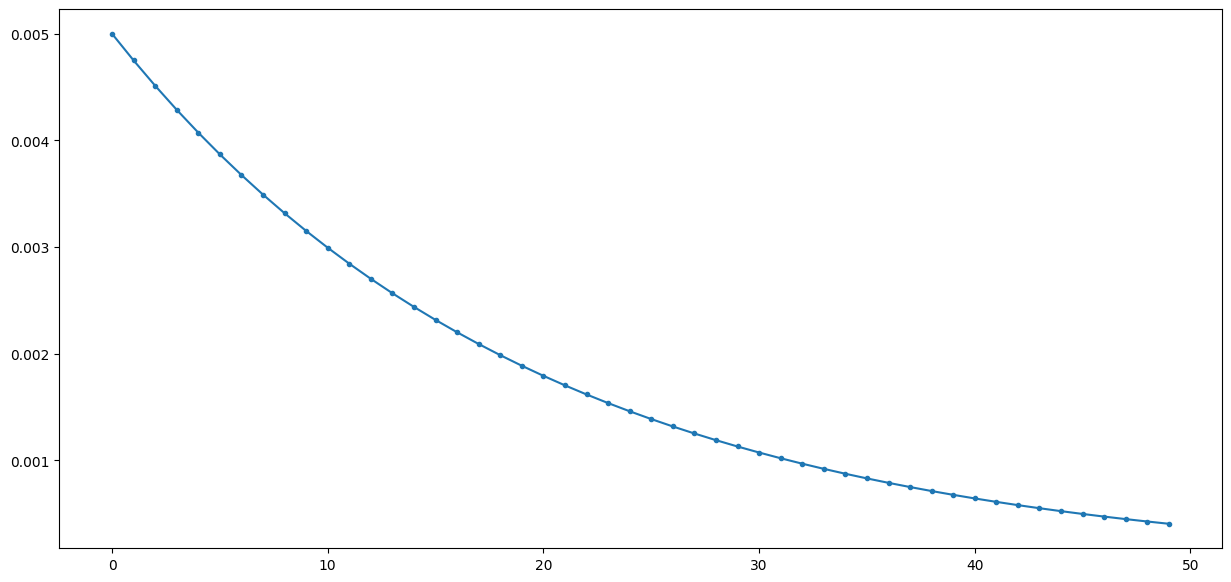

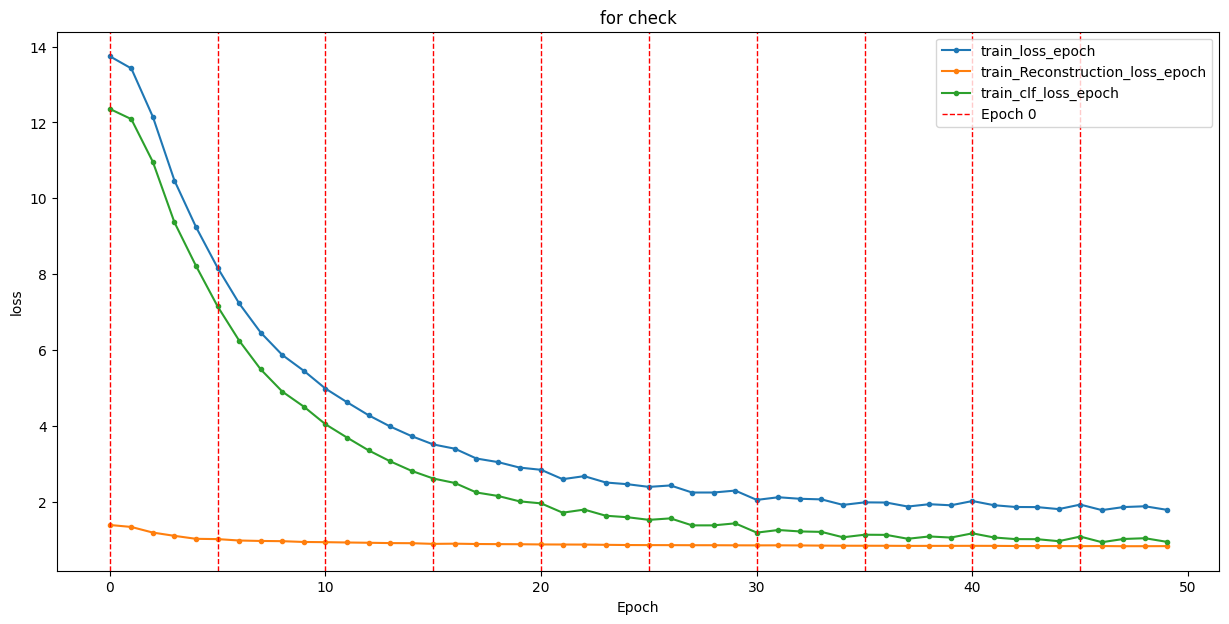

2025-07-27 23:20:18,033 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:20:18,049 INFO - tensorboard - No path found after /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/wholeData/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_3/events.out.tfevents.1753676387.woody.3041196.0 
2025-07-27 23:20:18,170 INFO - TemporalVAE.utils.utils_plot - Finish save images at: /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/wholeData/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_3/trainingLoss_train_Reconstruction_lo

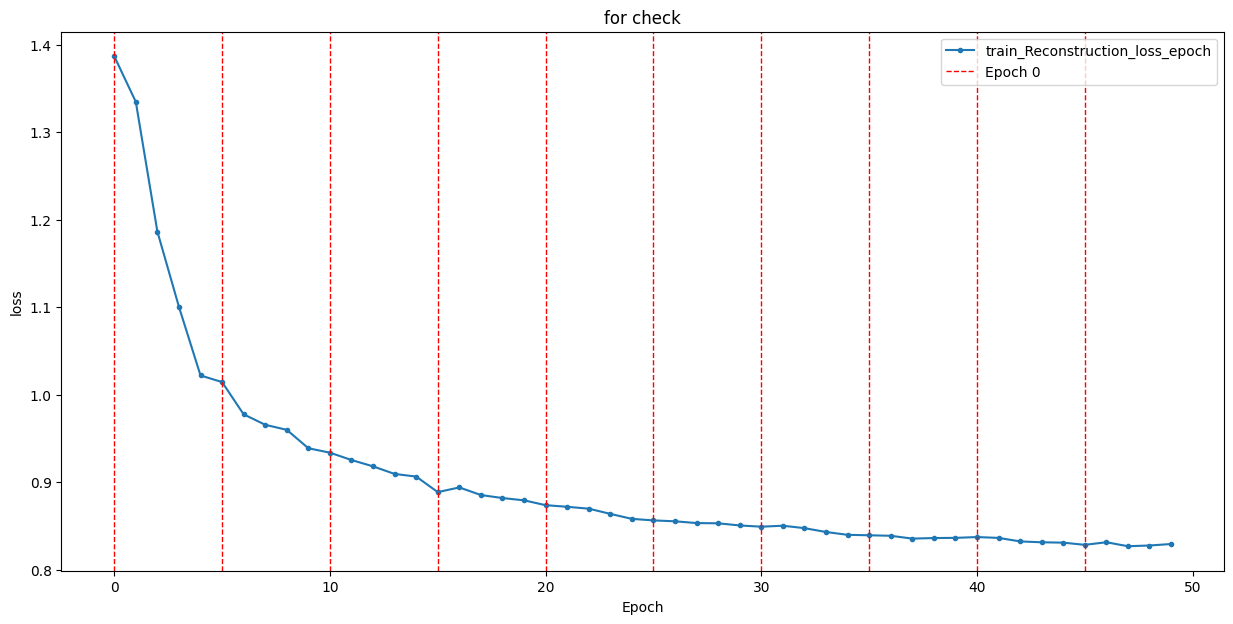

2025-07-27 23:20:18,281 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:20:18,294 INFO - tensorboard - No path found after /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/wholeData/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_3/events.out.tfevents.1753676387.woody.3041196.0 


<Figure size 1500x700 with 0 Axes>

In [14]:
res = onlyTrain_model(
    sc_expression_df, 
    donor_dic,
    special_path_str,
    cell_time,
    time_standard_type, 
    config, 
    train_epoch_num,
    plot_latentSpaceUmap=False, 
    plot_trainingLossLine=True, 
    time_saved_asFloat=True, 
    batch_dic=batch_dic, 
    donor_str="day",
    batch_size=int(batch_size)
)
# 2023-10-24 17:44:31 batch as 10,000 due to overfit, 
# batch size as 100,000 may be have different result

sc_expression_train, y_time_nor_train, donor_index_train, runner, experiment, _m, \
train_clf_result, label_dic, total_result = res

In [15]:
predict_donors_df = pd.DataFrame(train_clf_result, 
                                 columns=["pseudotime"], 
                                 index=cell_time.index)
predict_donors_df['predicted_time'] = predict_donors_df['pseudotime'].apply(
    denormalize, 
    args=(min(label_dic.keys()) / 100, max(label_dic.keys()) / 100,
          min(label_dic.values()), max(label_dic.values()))
)

predict_donors_df

,pseudotime,predicted_time
D6N1B23,-4.497684,6.401853
D6N1B6,-4.569240,6.344608
D6N1S1,-4.377456,6.498035
D6N1S15,-4.521165,6.383068
D6N1S19,-4.503838,6.396930
...,...,...
D14_3S16,4.805198,13.844159
D14_3S9,4.725020,13.780016
D14_2S2,4.722881,13.778305
D14_2B1,4.775031,13.820025


In [16]:
cell_time = pd.concat([cell_time, predict_donors_df], axis=1)
cell_time

,time,day,dataset_label,donor,cell_type,title,species,n_genes,pseudotime,predicted_time
D6N1B23,6.0,D6_xiang19,Xiang,D6_xiang19,Inner cell mass,Embryo_D6N1B23,human,520,-4.497684,6.401853
D6N1B6,6.0,D6_xiang19,Xiang,D6_xiang19,Inner cell mass,Embryo_D6N1B6,human,622,-4.569240,6.344608
D6N1S1,6.0,D6_xiang19,Xiang,D6_xiang19,Epiblast,Embryo_D6N1S1,human,482,-4.377456,6.498035
D6N1S15,6.0,D6_xiang19,Xiang,D6_xiang19,Epiblast,Embryo_D6N1S15,human,525,-4.521165,6.383068
D6N1S19,6.0,D6_xiang19,Xiang,D6_xiang19,Inner cell mass,Embryo_D6N1S19,human,494,-4.503838,6.396930
...,...,...,...,...,...,...,...,...,...,...
D14_3S16,14.0,D14_xiang19,Xiang,D14_xiang19,Epiblast,Embryo_D14_3S16,human,537,4.805198,13.844159
D14_3S9,14.0,D14_xiang19,Xiang,D14_xiang19,Cytotrophoblast,Embryo_D14_3S9,human,477,4.725020,13.780016
D14_2S2,14.0,D14_xiang19,Xiang,D14_xiang19,Syncytiotrophoblast,Embryo_D14_2S2,human,688,4.722881,13.778305
D14_2B1,14.0,D14_xiang19,Xiang,D14_xiang19,Extravillous Cytotrophoblast,Embryo_D14_2B1,human,687,4.775031,13.820025


In [17]:
plt_image_adata = ad.AnnData(X=total_result["mu"].cpu().numpy())
plt_image_adata.obs = cell_time[["time", "predicted_time", "dataset_label", "cell_type", "day"]]
plt_image_adata

AnnData object with n_obs × n_vars = 555 × 50
    obs: 'time', 'predicted_time', 'dataset_label', 'cell_type', 'day'

/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
... storing 'dataset_label' as categorical
... storing 'cell_type' as categorical
... storing 'day' as categorical


latent mu save as /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50//n50_latent_mu.h5ad


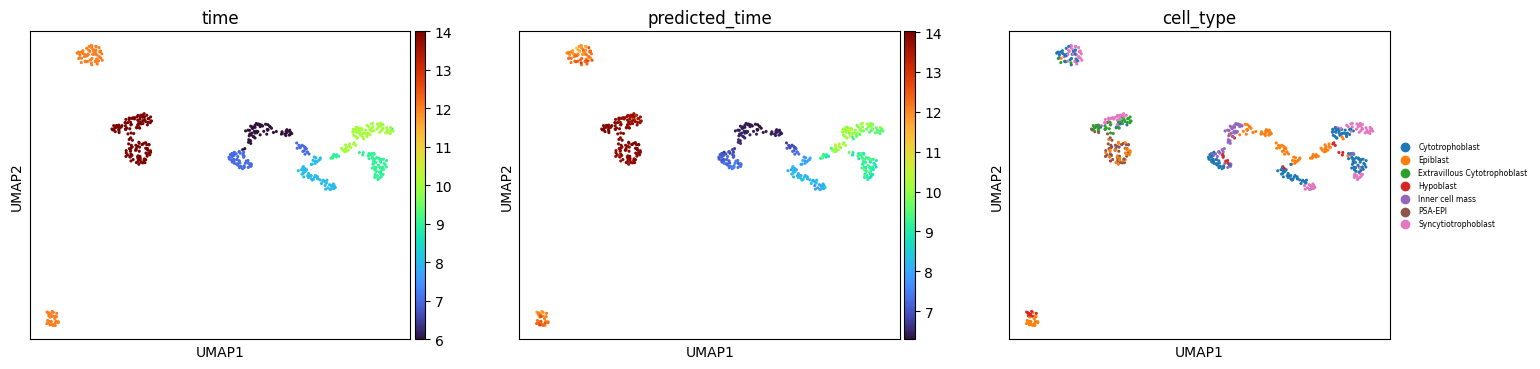

figure save as /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50//n50_latentSpace_umap_byScanpy.png


AnnData object with n_obs × n_vars = 555 × 50
    obs: 'time', 'predicted_time', 'dataset_label', 'cell_type', 'day'
    uns: 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [18]:
plt_umap_byScanpy(plt_image_adata.copy(),
                  ["time", "predicted_time", "cell_type"],
                  save_path=save_file_name, mode=None, figure_size=(5, 4), 
                  color_map="turbo", n_neighbors=80, n_pcs=10, special_file_name_str="n50_")

## If you want to do multiple loop calculations: test on one donor and train on other donors.

2025-07-27 23:20:27,057 INFO - __main__ - start task: k-fold test with ['D10_xiang19', 'D12_xiang19', 'D14_xiang19', 'D6_xiang19', 'D7_xiang19', 'D8_xiang19', 'D9_xiang19']. 
2025-07-27 23:20:27,279 INFO - TemporalVAE.utils.utils_project - the 1/7 fold train, use donor-D10_xiang19 as test set 
2025-07-27 23:20:27,294 INFO - TemporalVAE.utils.utils_project - Set x_sc_train data with shape (gene, cells): torch.Size([1188, 478]) 
2025-07-27 23:20:27,295 INFO - TemporalVAE.utils.utils_project - Set x_sc_test data with shape (gene, cells): torch.Size([1188, 77]) 
2025-07-27 23:20:27,318 INFO - TemporalVAE.utils.utils_project - label dictionary: {600: -5.0, 700: -3.75, 800: -2.5, 900: -1.25, 1200: 2.5, 1400: 5.0, 1000: 0.0} 
2025-07-27 23:20:27,319 INFO - TemporalVAE.utils.utils_project - Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [ 600.  700.  800.  900. 1200. 1400.], shape: torch.Size([478]), 
detail: [-5.   -3.75 -2.5  -1.25  2.5   5.  ] 
2025-07-27

Free Memory Percentage: 92.90%
[INFO] GPU device 7 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 6 - total: 24.0GB; - memory free: 22.394GB.
[INFO] GPU device 5 - total: 24.0GB; - memory free: 18.705GB.
[INFO] GPU device 4 - total: 24.0GB; - memory free: 23.154GB.
[INFO] GPU device 3 - total: 24.0GB; - memory free: 20.808GB.
[INFO] GPU device 2 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 1 - total: 24.0GB; - memory free: 23.68GB.
[INFO] GPU device 0 - total: 24.0GB; - memory free: 23.68GB.

[INFO] more than 5% free memory, Auto select GPU device 1,- memory free: 23.68GB
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


2025-07-27 23:20:27,859 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
2025-07-27 23:20:27,862 INFO - pytorch_lightning.callbacks.model_summary - 
  | Name  | Type                                                         | Params
---------------------------------------------------------------------------------------
0 | model | SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial | 5.0 M 
---------------------------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.840    Total estimated model params size (MB) 


Sanity Checking DataLoader 0:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s]

/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 40.73it/s, v_num=1, train_loss_step=16.00, train_Reconstruction_loss_step=1.420, train_KLD_step=-6.81, train_clf_loss_step=14.60]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 25.88it/s, v_num=1, train_loss_step=16.00, train_Reconstruction_loss_step=1.420, train_KLD_step=-6.81, train_clf_loss_step=14.60]
Epoch 0: 100%|█| 1/1 [00:00<00:00, 24.22it/s, v_num=1, train_loss_step=16.00, train_Reconstruction_loss_step=1.420, train_KLD_step=-6.81, train_clf_loss_step=14.60, train_loss_epochEpoch train loss: {'train_loss_step': tensor(16.0395, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.4169, device='cuda:1'), 'train_KLD_step': tensor(-6.8116, device='cuda:1'), 'train_clf_loss_step': tensor(14.6209, device='cuda:1'), 'val_loss': tensor(0.8403, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.8306, device='cuda:1'), 'val_KLD': tensor(-0.2782, device='cuda:1'), 'val_clf_loss': tensor(0.0

2025-07-27 23:20:53,898 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=50` reached. 


Epoch 49: 100%|█| 1/1 [00:00<00:00,  2.17it/s, v_num=1, train_loss_step=2.180, train_Reconstruction_loss_step=0.845, train_KLD_step=-56.6, train_clf_loss_step=1.320, train_loss_epoc

2025-07-27 23:20:53,958 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:20:53,965 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.52it/s]

2025-07-27 23:20:54,032 INFO - TemporalVAE.utils.utils_project - this epoch final, on test data:[{'test_loss_epoch': 2.984400749206543, 'test_Reconstruction_loss_epoch': 0.7414776086807251, 'test_KLD_epoch': -9.270943641662598, 'test_clf_loss_epoch': 2.240605354309082}] 
2025-07-27 23:20:54,034 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:20:54,038 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dat


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_KLD_epoch              -9.270943641662598
test_Reconstruction_loss_epoch      0.7414776086807251
     test_clf_loss_epoch            2.240605354309082
       test_loss_epoch              2.984400749206543
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 123.78it/s]

2025-07-27 23:20:54,080 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:20:54,085 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 170.09it/s]

2025-07-27 23:20:54,125 INFO - TemporalVAE.utils.utils_project - The Array does not contain NaN values 
2025-07-27 23:20:54,126 INFO - TemporalVAE.utils.utils_project - predicted time of test donor is continuous. 
2025-07-27 23:20:54,127 INFO - TemporalVAE.utils.utils_project - Plot training loss line for check. 
2025-07-27 23:20:54,148 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D10_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676427.woody.3041196.1 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_d

2025-07-27 23:20:54,332 INFO - TemporalVAE.utils.utils_plot - Finish save images at: /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D10_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/trainingLoss_test_clf_loss_epoch_train_clf_loss_epoch_val_clf_loss_D10_xiang19.png 


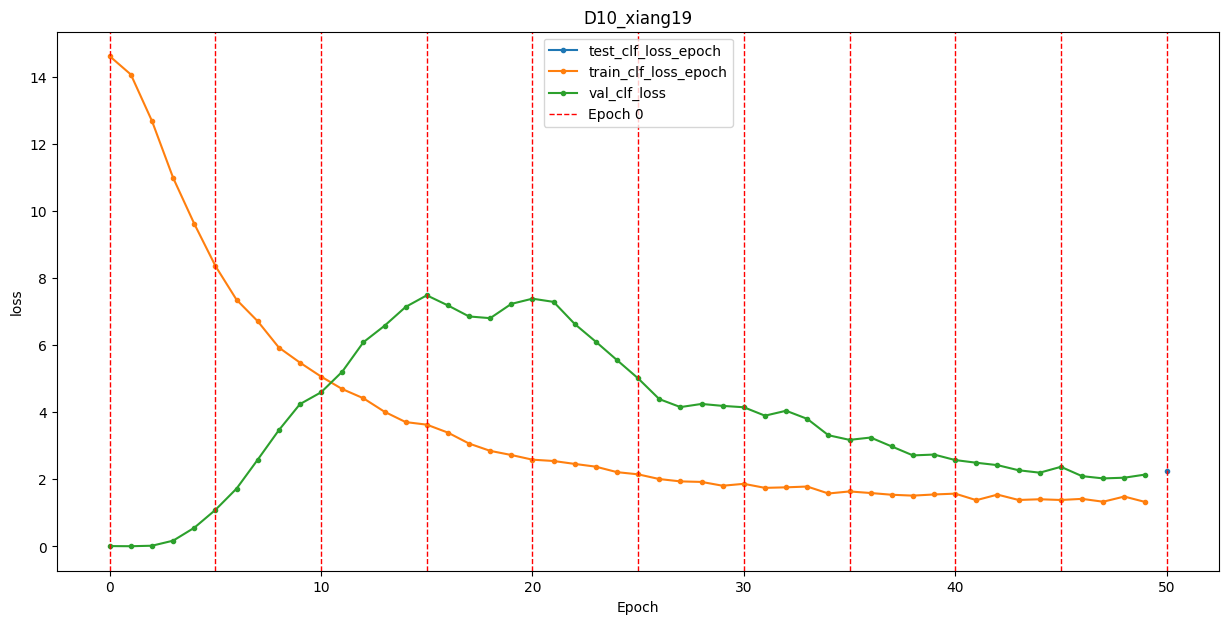

2025-07-27 23:20:54,470 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:20:54,493 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D10_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676427.woody.3041196.1 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D10_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676453.woody.3041196.2 
2025-07-27 23:20:54,494 INFO - tensorboard - No path f

Free Memory Percentage: 93.16%
[INFO] GPU device 7 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 6 - total: 24.0GB; - memory free: 22.394GB.
[INFO] GPU device 5 - total: 24.0GB; - memory free: 18.705GB.
[INFO] GPU device 4 - total: 24.0GB; - memory free: 23.154GB.
[INFO] GPU device 3 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 2 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 1 - total: 24.0GB; - memory free: 23.365GB.
[INFO] GPU device 0 - total: 24.0GB; - memory free: 23.68GB.

[INFO] more than 5% free memory, Auto select GPU device 0,- memory free: 23.68GB
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


2025-07-27 23:20:55,644 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
2025-07-27 23:20:55,650 INFO - pytorch_lightning.callbacks.model_summary - 
  | Name  | Type                                                         | Params
---------------------------------------------------------------------------------------
0 | model | SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial | 5.0 M 
---------------------------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.840    Total estimated model params size (MB) 


Sanity Checking DataLoader 0:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s]

/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 37.80it/s, v_num=1, train_loss_step=15.30, train_Reconstruction_loss_step=1.390, train_KLD_step=-6.77, train_clf_loss_step=13.90]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 23.91it/s, v_num=1, train_loss_step=15.30, train_Reconstruction_loss_step=1.390, train_KLD_step=-6.77, train_clf_loss_step=13.90]
Epoch 0: 100%|█| 1/1 [00:00<00:00, 22.21it/s, v_num=1, train_loss_step=15.30, train_Reconstruction_loss_step=1.390, train_KLD_step=-6.77, train_clf_loss_step=13.90, train_loss_epochEpoch train loss: {'train_loss_step': tensor(15.2946, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.3854, device='cuda:0'), 'train_KLD_step': tensor(-6.7729, device='cuda:0'), 'train_clf_loss_step': tensor(13.9075, device='cuda:0'), 'val_loss': tensor(7.9168, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.0120, device='cuda:0'), 'val_KLD': tensor(-0.2874, device='cuda:0'), 'val_clf_loss': tensor(6.9

2025-07-27 23:21:23,594 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=50` reached. 


Epoch 49: 100%|█| 1/1 [00:00<00:00,  1.84it/s, v_num=1, train_loss_step=2.160, train_Reconstruction_loss_step=0.816, train_KLD_step=-64.2, train_clf_loss_step=1.320, train_loss_epoc

2025-07-27 23:21:23,645 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:21:23,652 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.81it/s]

2025-07-27 23:21:23,732 INFO - TemporalVAE.utils.utils_project - this epoch final, on test data:[{'test_loss_epoch': 2.3933019638061523, 'test_Reconstruction_loss_epoch': 0.925974428653717, 'test_KLD_epoch': -47.6920051574707, 'test_clf_loss_epoch': 1.4554044008255005}] 
2025-07-27 23:21:23,733 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:21:23,738 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dat


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_KLD_epoch              -47.6920051574707
test_Reconstruction_loss_epoch      0.925974428653717
     test_clf_loss_epoch            1.4554044008255005
       test_loss_epoch              2.3933019638061523
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 156.17it/s]

2025-07-27 23:21:23,780 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:21:23,785 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.71it/s]

2025-07-27 23:21:23,826 INFO - TemporalVAE.utils.utils_project - The Array does not contain NaN values 
2025-07-27 23:21:23,827 INFO - TemporalVAE.utils.utils_project - predicted time of test donor is continuous. 
2025-07-27 23:21:23,828 INFO - TemporalVAE.utils.utils_project - Plot training loss line for check. 
2025-07-27 23:21:23,847 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D12_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676455.woody.3041196.3 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_d

2025-07-27 23:21:23,869 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D12_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676455.woody.3041196.3 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D12_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676483.woody.3041196.4 
2025-07-27 23:21:23,870 INFO - tensorboard - No path found after /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_Temporal

<Figure size 1500x700 with 0 Axes>

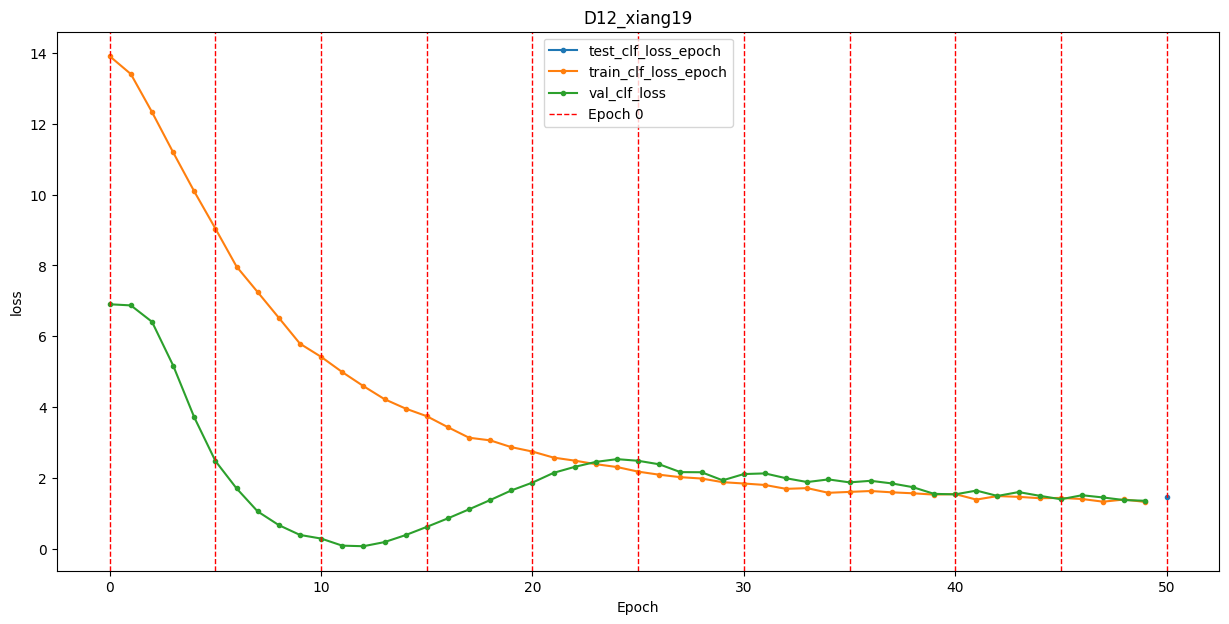

2025-07-27 23:21:24,131 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:21:24,151 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D12_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676455.woody.3041196.3 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D12_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676483.woody.3041196.4 
2025-07-27 23:21:24,152 INFO - tensorboard - No path f

Free Memory Percentage: 93.00%
[INFO] GPU device 7 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 6 - total: 24.0GB; - memory free: 22.394GB.
[INFO] GPU device 5 - total: 24.0GB; - memory free: 18.705GB.
[INFO] GPU device 4 - total: 24.0GB; - memory free: 23.154GB.
[INFO] GPU device 3 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 2 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 1 - total: 24.0GB; - memory free: 23.369GB.
[INFO] GPU device 0 - total: 24.0GB; - memory free: 23.367GB.

[INFO] more than 5% free memory, Auto select GPU device 1,- memory free: 23.369GB
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======
                                                                                                                                                                                     

/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 46.16it/s, v_num=1, train_loss_step=9.540, train_Reconstruction_loss_step=1.300, train_KLD_step=-6.80, train_clf_loss_step=8.230]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 23.96it/s, v_num=1, train_loss_step=9.540, train_Reconstruction_loss_step=1.300, train_KLD_step=-6.80, train_clf_loss_step=8.230]
Epoch 0: 100%|█| 1/1 [00:00<00:00, 21.65it/s, v_num=1, train_loss_step=9.540, train_Reconstruction_loss_step=1.300, train_KLD_step=-6.80, train_clf_loss_step=8.230, train_loss_epochEpoch train loss: {'train_loss_step': tensor(9.5403, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.3038, device='cuda:1'), 'train_KLD_step': tensor(-6.7959, device='cuda:1'), 'train_clf_loss_step': tensor(8.2348, device='cuda:1'), 'val_loss': tensor(27.6250, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2592, device='cuda:1'), 'val_KLD': tensor(-0.2877, device='cuda:1'), 'val_clf_loss': tensor(26.3

2025-07-27 23:21:54,154 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=50` reached. 


Epoch 49: 100%|█| 1/1 [00:00<00:00,  2.15it/s, v_num=1, train_loss_step=2.120, train_Reconstruction_loss_step=0.775, train_KLD_step=-59.4, train_clf_loss_step=1.330, train_loss_epoc

2025-07-27 23:21:54,191 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:21:54,197 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.20it/s]

2025-07-27 23:21:54,267 INFO - TemporalVAE.utils.utils_project - this epoch final, on test data:[{'test_loss_epoch': 3.3534467220306396, 'test_Reconstruction_loss_epoch': 1.1036022901535034, 'test_KLD_epoch': -156.70262145996094, 'test_clf_loss_epoch': 2.2106688022613525}] 
2025-07-27 23:21:54,268 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:21:54,274 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_KLD_epoch             -156.70262145996094
test_Reconstruction_loss_epoch      1.1036022901535034
     test_clf_loss_epoch            2.2106688022613525
       test_loss_epoch              3.3534467220306396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 116.71it/s]

2025-07-27 23:21:54,317 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:21:54,321 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.08it/s]


2025-07-27 23:21:54,372 INFO - TemporalVAE.utils.utils_project - The Array does not contain NaN values 
2025-07-27 23:21:54,373 INFO - TemporalVAE.utils.utils_project - predicted time of test donor is continuous. 
2025-07-27 23:21:54,374 INFO - TemporalVAE.utils.utils_project - Plot training loss line for check. 
2025-07-27 23:21:54,405 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D14_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676484.woody.3041196.5 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_d

<Figure size 1500x700 with 0 Axes>

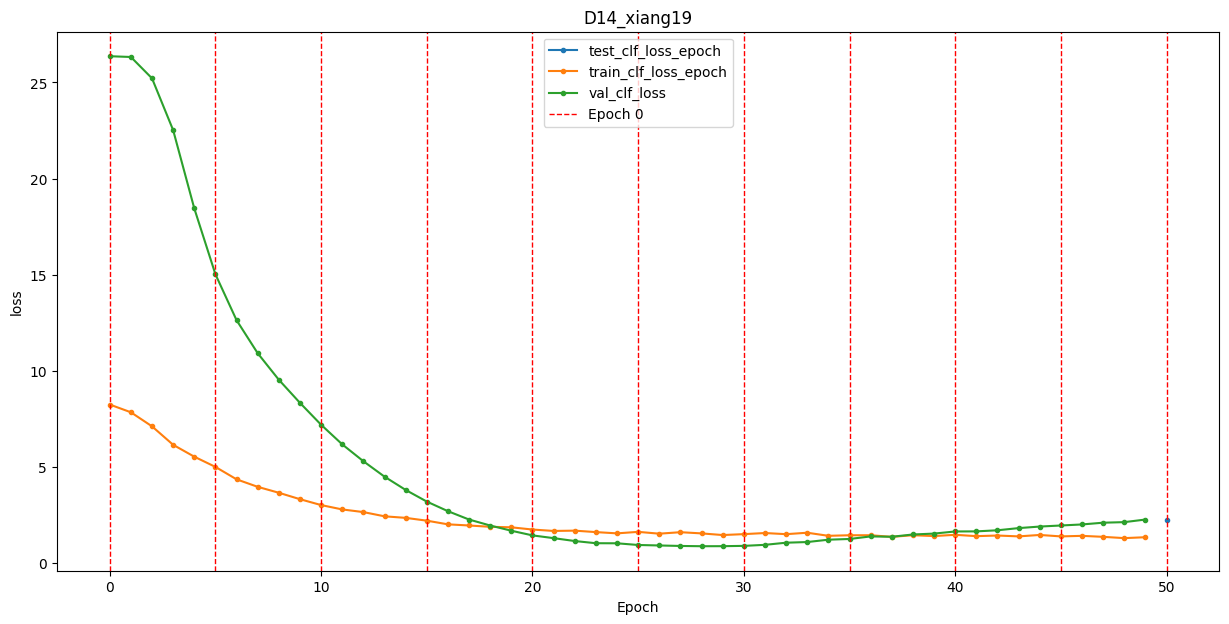

2025-07-27 23:21:54,683 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:21:54,701 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D14_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676484.woody.3041196.5 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D14_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676514.woody.3041196.6 
2025-07-27 23:21:54,703 INFO - tensorboard - No path f

Free Memory Percentage: 92.96%
[INFO] GPU device 7 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 6 - total: 24.0GB; - memory free: 22.394GB.
[INFO] GPU device 5 - total: 24.0GB; - memory free: 18.705GB.
[INFO] GPU device 4 - total: 24.0GB; - memory free: 23.154GB.
[INFO] GPU device 3 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 2 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 1 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 0 - total: 24.0GB; - memory free: 23.369GB.

[INFO] more than 5% free memory, Auto select GPU device 0,- memory free: 23.369GB
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======
                                                                                                                                                                                     

/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 48.58it/s, v_num=1, train_loss_step=12.70, train_Reconstruction_loss_step=1.380, train_KLD_step=-6.78, train_clf_loss_step=11.30]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 32.15it/s, v_num=1, train_loss_step=12.70, train_Reconstruction_loss_step=1.380, train_KLD_step=-6.78, train_clf_loss_step=11.30]
Epoch 0: 100%|█| 1/1 [00:00<00:00, 30.38it/s, v_num=1, train_loss_step=12.70, train_Reconstruction_loss_step=1.380, train_KLD_step=-6.78, train_clf_loss_step=11.30, train_loss_epochEpoch train loss: {'train_loss_step': tensor(12.6817, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.3760, device='cuda:0'), 'train_KLD_step': tensor(-6.7764, device='cuda:0'), 'train_clf_loss_step': tensor(11.3040, device='cuda:0'), 'val_loss': tensor(25.1060, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.0710, device='cuda:0'), 'val_KLD': tensor(-0.3127, device='cuda:0'), 'val_clf_loss': tensor(24

2025-07-27 23:22:22,583 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=50` reached. 


Epoch 49: 100%|█| 1/1 [00:00<00:00,  2.12it/s, v_num=1, train_loss_step=1.990, train_Reconstruction_loss_step=0.801, train_KLD_step=-58.4, train_clf_loss_step=1.170, train_loss_epoc

2025-07-27 23:22:22,621 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:22:22,627 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.34it/s]

2025-07-27 23:22:22,690 INFO - TemporalVAE.utils.utils_project - this epoch final, on test data:[{'test_loss_epoch': 2.097731113433838, 'test_Reconstruction_loss_epoch': 0.9847589135169983, 'test_KLD_epoch': -147.63487243652344, 'test_clf_loss_epoch': 1.0760633945465088}] 
2025-07-27 23:22:22,692 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:22:22,698 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_d


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_KLD_epoch             -147.63487243652344
test_Reconstruction_loss_epoch      0.9847589135169983
     test_clf_loss_epoch            1.0760633945465088
       test_loss_epoch              2.097731113433838
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.22it/s]

2025-07-27 23:22:22,748 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:22:22,753 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 138.32it/s]


2025-07-27 23:22:22,790 INFO - TemporalVAE.utils.utils_project - The Array does not contain NaN values 
2025-07-27 23:22:22,791 INFO - TemporalVAE.utils.utils_project - predicted time of test donor is continuous. 
2025-07-27 23:22:22,792 INFO - TemporalVAE.utils.utils_project - Plot training loss line for check. 
2025-07-27 23:22:22,811 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D6_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676515.woody.3041196.7 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_di

<Figure size 1500x700 with 0 Axes>

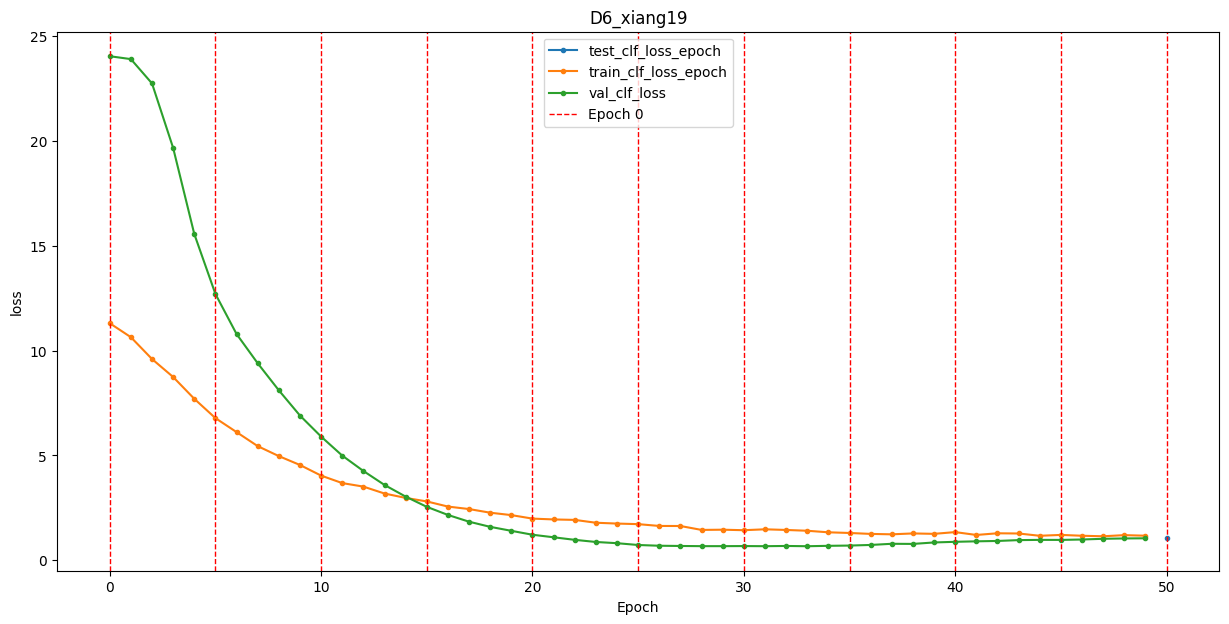

2025-07-27 23:22:23,086 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:22:23,104 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D6_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676515.woody.3041196.7 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D6_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676542.woody.3041196.8 
2025-07-27 23:22:23,106 INFO - tensorboard - No path fou

Free Memory Percentage: 93.08%
[INFO] GPU device 7 - total: 24.0GB; - memory free: 20.808GB.
[INFO] GPU device 6 - total: 24.0GB; - memory free: 22.394GB.
[INFO] GPU device 5 - total: 24.0GB; - memory free: 18.705GB.
[INFO] GPU device 4 - total: 24.0GB; - memory free: 23.154GB.
[INFO] GPU device 3 - total: 24.0GB; - memory free: 23.68GB.
[INFO] GPU device 2 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 1 - total: 24.0GB; - memory free: 23.369GB.
[INFO] GPU device 0 - total: 24.0GB; - memory free: 23.367GB.

[INFO] more than 5% free memory, Auto select GPU device 3,- memory free: 23.68GB
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


2025-07-27 23:22:24,038 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
2025-07-27 23:22:24,041 INFO - pytorch_lightning.callbacks.model_summary - 
  | Name  | Type                                                         | Params
---------------------------------------------------------------------------------------
0 | model | SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial | 5.0 M 
---------------------------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.840    Total estimated model params size (MB) 


Sanity Checking DataLoader 0:   0%|                                                                                                                            | 0/1 [00:00<?, ?it/s]

/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 38.78it/s, v_num=1, train_loss_step=14.30, train_Reconstruction_loss_step=1.400, train_KLD_step=-6.79, train_clf_loss_step=12.90]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 23.93it/s, v_num=1, train_loss_step=14.30, train_Reconstruction_loss_step=1.400, train_KLD_step=-6.79, train_clf_loss_step=12.90]
Epoch 0: 100%|█| 1/1 [00:00<00:00, 22.22it/s, v_num=1, train_loss_step=14.30, train_Reconstruction_loss_step=1.400, train_KLD_step=-6.79, train_clf_loss_step=12.90, train_loss_epochEpoch train loss: {'train_loss_step': tensor(14.2653, device='cuda:3'), 'train_Reconstruction_loss_step': tensor(1.4019, device='cuda:3'), 'train_KLD_step': tensor(-6.7875, device='cuda:3'), 'train_clf_loss_step': tensor(12.8617, device='cuda:3'), 'val_loss': tensor(14.3166, device='cuda:3'), 'val_Reconstruction_loss': tensor(0.8899, device='cuda:3'), 'val_KLD': tensor(-0.2804, device='cuda:3'), 'val_clf_loss': tensor(13

2025-07-27 23:23:00,599 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=50` reached. 


Epoch 49: 100%|█| 1/1 [00:00<00:00,  1.03it/s, v_num=1, train_loss_step=2.110, train_Reconstruction_loss_step=0.825, train_KLD_step=-59.2, train_clf_loss_step=1.270, train_loss_epoc

2025-07-27 23:23:00,646 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:23:00,653 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.61it/s]

2025-07-27 23:23:00,734 INFO - TemporalVAE.utils.utils_project - this epoch final, on test data:[{'test_loss_epoch': 2.132779836654663, 'test_Reconstruction_loss_epoch': 0.8212012052536011, 'test_KLD_epoch': -60.207550048828125, 'test_clf_loss_epoch': 1.2965267896652222}] 
2025-07-27 23:23:00,736 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:23:00,740 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_d


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_KLD_epoch             -60.207550048828125
test_Reconstruction_loss_epoch      0.8212012052536011
     test_clf_loss_epoch            1.2965267896652222
       test_loss_epoch              2.132779836654663
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.77it/s]

2025-07-27 23:23:00,784 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:23:00,789 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 140.89it/s]

2025-07-27 23:23:00,822 INFO - TemporalVAE.utils.utils_project - The Array does not contain NaN values 
2025-07-27 23:23:00,823 INFO - TemporalVAE.utils.utils_project - predicted time of test donor is continuous. 
2025-07-27 23:23:00,824 INFO - TemporalVAE.utils.utils_project - Plot training loss line for check. 
2025-07-27 23:23:00,842 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D7_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676544.woody.3041196.9 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_di

2025-07-27 23:23:01,004 INFO - TemporalVAE.utils.utils_plot - Finish save images at: /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D7_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/trainingLoss_test_clf_loss_epoch_train_clf_loss_epoch_val_clf_loss_D7_xiang19.png 


<Figure size 1500x700 with 0 Axes>

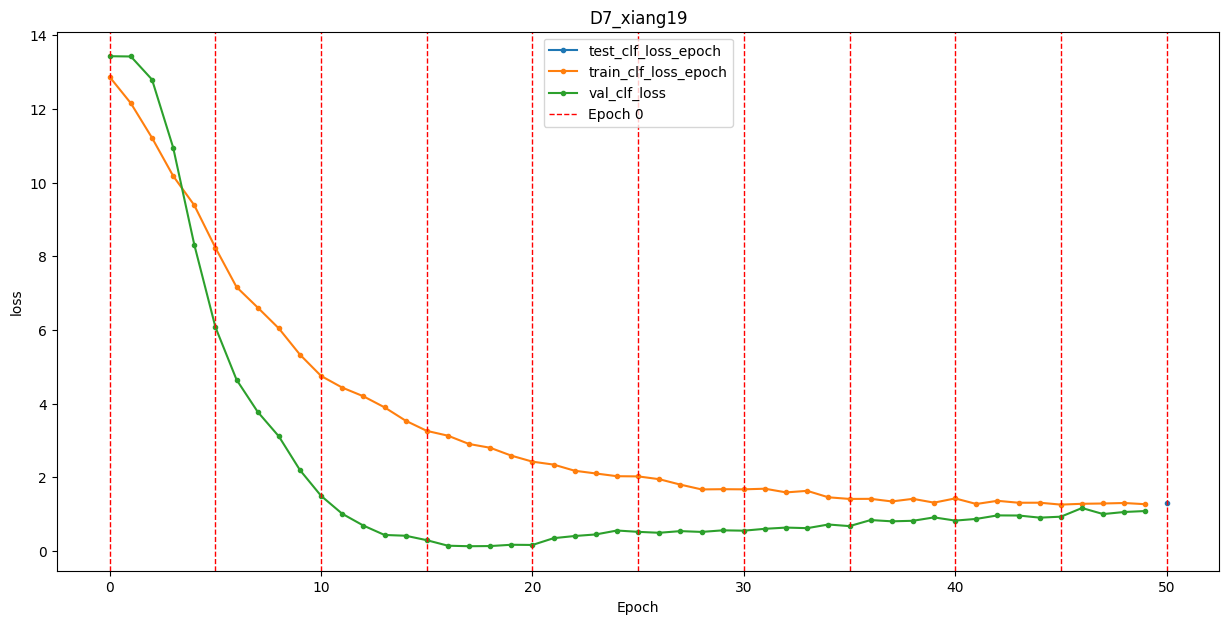

2025-07-27 23:23:01,126 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:23:01,144 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D7_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676544.woody.3041196.9 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D7_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676580.woody.3041196.10 
2025-07-27 23:23:01,146 INFO - tensorboard - No path fo

Free Memory Percentage: 92.97%
[INFO] GPU device 7 - total: 24.0GB; - memory free: 20.808GB.
[INFO] GPU device 6 - total: 24.0GB; - memory free: 22.394GB.
[INFO] GPU device 5 - total: 24.0GB; - memory free: 18.705GB.
[INFO] GPU device 4 - total: 24.0GB; - memory free: 23.154GB.
[INFO] GPU device 3 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 2 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 1 - total: 24.0GB; - memory free: 23.369GB.
[INFO] GPU device 0 - total: 24.0GB; - memory free: 23.369GB.

[INFO] more than 5% free memory, Auto select GPU device 1,- memory free: 23.369GB
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======
                                                                                                                                                                                     

/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 49.09it/s, v_num=1, train_loss_step=15.20, train_Reconstruction_loss_step=1.400, train_KLD_step=-6.80, train_clf_loss_step=13.80]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 31.61it/s, v_num=1, train_loss_step=15.20, train_Reconstruction_loss_step=1.400, train_KLD_step=-6.80, train_clf_loss_step=13.80]
Epoch 0: 100%|█| 1/1 [00:00<00:00, 29.75it/s, v_num=1, train_loss_step=15.20, train_Reconstruction_loss_step=1.400, train_KLD_step=-6.80, train_clf_loss_step=13.80, train_loss_epochEpoch train loss: {'train_loss_step': tensor(15.2092, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.4012, device='cuda:1'), 'train_KLD_step': tensor(-6.8040, device='cuda:1'), 'train_clf_loss_step': tensor(13.8063, device='cuda:1'), 'val_loss': tensor(6.6290, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.8738, device='cuda:1'), 'val_KLD': tensor(-0.2723, device='cuda:1'), 'val_clf_loss': tensor(5.7

2025-07-27 23:23:35,732 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=50` reached. 


Epoch 49: 100%|█| 1/1 [00:00<00:00,  2.26it/s, v_num=1, train_loss_step=2.120, train_Reconstruction_loss_step=0.835, train_KLD_step=-60.4, train_clf_loss_step=1.270, train_loss_epoc

2025-07-27 23:23:35,767 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:23:35,774 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.98it/s]

2025-07-27 23:23:35,857 INFO - TemporalVAE.utils.utils_project - this epoch final, on test data:[{'test_loss_epoch': 2.4768106937408447, 'test_Reconstruction_loss_epoch': 0.7372809648513794, 'test_KLD_epoch': -37.31700897216797, 'test_clf_loss_epoch': 1.7302005290985107}] 
2025-07-27 23:23:35,858 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:23:35,865 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_d


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_KLD_epoch              -37.31700897216797
test_Reconstruction_loss_epoch      0.7372809648513794
     test_clf_loss_epoch            1.7302005290985107
       test_loss_epoch              2.4768106937408447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.35it/s]


2025-07-27 23:23:35,961 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:23:35,967 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.57it/s]

2025-07-27 23:23:36,055 INFO - TemporalVAE.utils.utils_project - The Array does not contain NaN values 
2025-07-27 23:23:36,056 INFO - TemporalVAE.utils.utils_project - predicted time of test donor is continuous. 
2025-07-27 23:23:36,057 INFO - TemporalVAE.utils.utils_project - Plot training loss line for check. 


2025-07-27 23:23:36,098 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D8_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676581.woody.3041196.11 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D8_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676615.woody.3041196.12 
2025-07-27 23:23:36,100 INFO - tensorboard - No path found after /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_Temporal

<Figure size 1500x700 with 0 Axes>

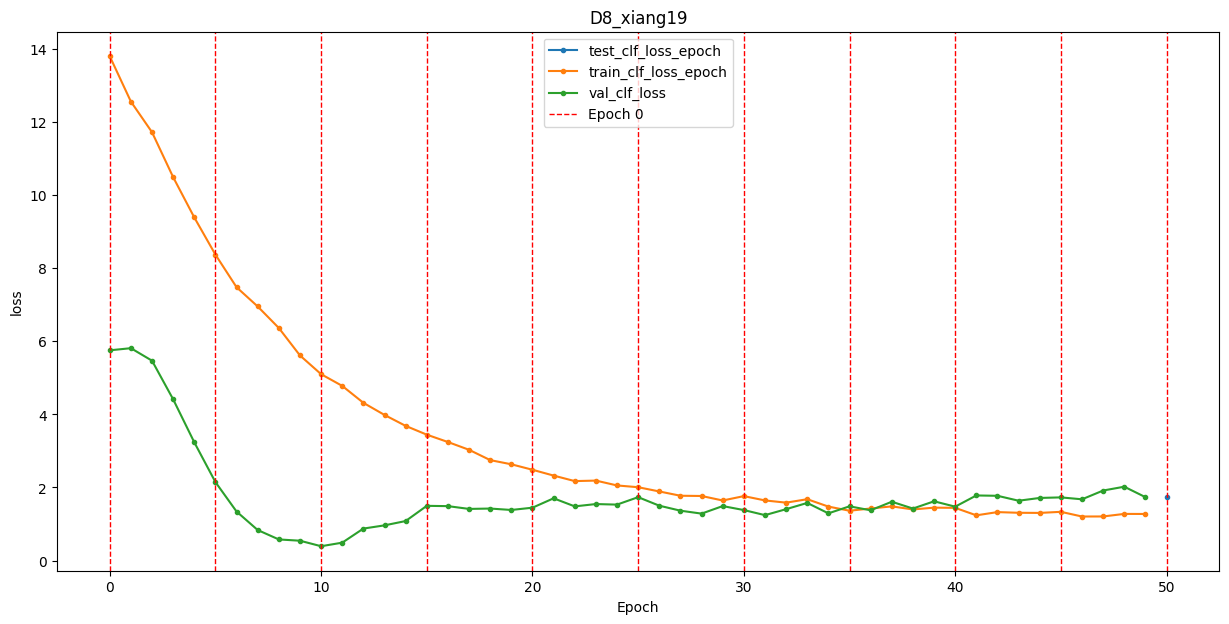

2025-07-27 23:23:36,404 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:23:36,422 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D8_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676581.woody.3041196.11 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D8_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676615.woody.3041196.12 
2025-07-27 23:23:36,424 INFO - tensorboard - No path f

Free Memory Percentage: 92.90%
[INFO] GPU device 7 - total: 24.0GB; - memory free: 20.808GB.
[INFO] GPU device 6 - total: 24.0GB; - memory free: 22.394GB.
[INFO] GPU device 5 - total: 24.0GB; - memory free: 18.705GB.
[INFO] GPU device 4 - total: 24.0GB; - memory free: 23.154GB.
[INFO] GPU device 3 - total: 24.0GB; - memory free: 23.369GB.
[INFO] GPU device 2 - total: 24.0GB; - memory free: 23.367GB.
[INFO] GPU device 1 - total: 24.0GB; - memory free: 23.365GB.
[INFO] GPU device 0 - total: 24.0GB; - memory free: 23.369GB.

[INFO] more than 5% free memory, Auto select GPU device 3,- memory free: 23.369GB
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======
                                                                                                                                                                                     

/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 47.78it/s, v_num=1, train_loss_step=15.40, train_Reconstruction_loss_step=1.410, train_KLD_step=-6.79, train_clf_loss_step=14.00]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████| 1/1 [00:00<00:00, 27.30it/s, v_num=1, train_loss_step=15.40, train_Reconstruction_loss_step=1.410, train_KLD_step=-6.79, train_clf_loss_step=14.00]
Epoch 0: 100%|█| 1/1 [00:00<00:00, 25.06it/s, v_num=1, train_loss_step=15.40, train_Reconstruction_loss_step=1.410, train_KLD_step=-6.79, train_clf_loss_step=14.00, train_loss_epochEpoch train loss: {'train_loss_step': tensor(15.3740, device='cuda:3'), 'train_Reconstruction_loss_step': tensor(1.4093, device='cuda:3'), 'train_KLD_step': tensor(-6.7863, device='cuda:3'), 'train_clf_loss_step': tensor(13.9630, device='cuda:3'), 'val_loss': tensor(2.1900, device='cuda:3'), 'val_Reconstruction_loss': tensor(0.8405, device='cuda:3'), 'val_KLD': tensor(-0.2746, device='cuda:3'), 'val_clf_loss': tensor(1.3

2025-07-27 23:24:09,356 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=50` reached. 


Epoch 49: 100%|█| 1/1 [00:00<00:00,  2.09it/s, v_num=1, train_loss_step=2.270, train_Reconstruction_loss_step=0.842, train_KLD_step=-57.4, train_clf_loss_step=1.420, train_loss_epoc

2025-07-27 23:24:09,395 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:24:09,401 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.80it/s]

2025-07-27 23:24:09,466 INFO - TemporalVAE.utils.utils_project - this epoch final, on test data:[{'test_loss_epoch': 1.7653675079345703, 'test_Reconstruction_loss_epoch': 0.7442957162857056, 'test_KLD_epoch': -19.81620216369629, 'test_clf_loss_epoch': 1.0161176919937134}] 
2025-07-27 23:24:09,467 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:24:09,473 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 
/ssd/users/yuanhua/envs/tvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_d


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 Runningstage.testing metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_KLD_epoch              -19.81620216369629
test_Reconstruction_loss_epoch      0.7442957162857056
     test_clf_loss_epoch            1.0161176919937134
       test_loss_epoch              1.7653675079345703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 108.65it/s]

2025-07-27 23:24:09,519 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-07-27 23:24:09,523 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7] 



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.18it/s]

2025-07-27 23:24:09,555 INFO - TemporalVAE.utils.utils_project - The Array does not contain NaN values 
2025-07-27 23:24:09,556 INFO - TemporalVAE.utils.utils_project - predicted time of test donor is continuous. 
2025-07-27 23:24:09,557 INFO - TemporalVAE.utils.utils_project - Plot training loss line for check. 


2025-07-27 23:24:09,575 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D9_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676616.woody.3041196.13 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D9_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676649.woody.3041196.14 
2025-07-27 23:24:09,577 INFO - tensorboard - No path found after /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_Temporal

<Figure size 1500x700 with 0 Axes>

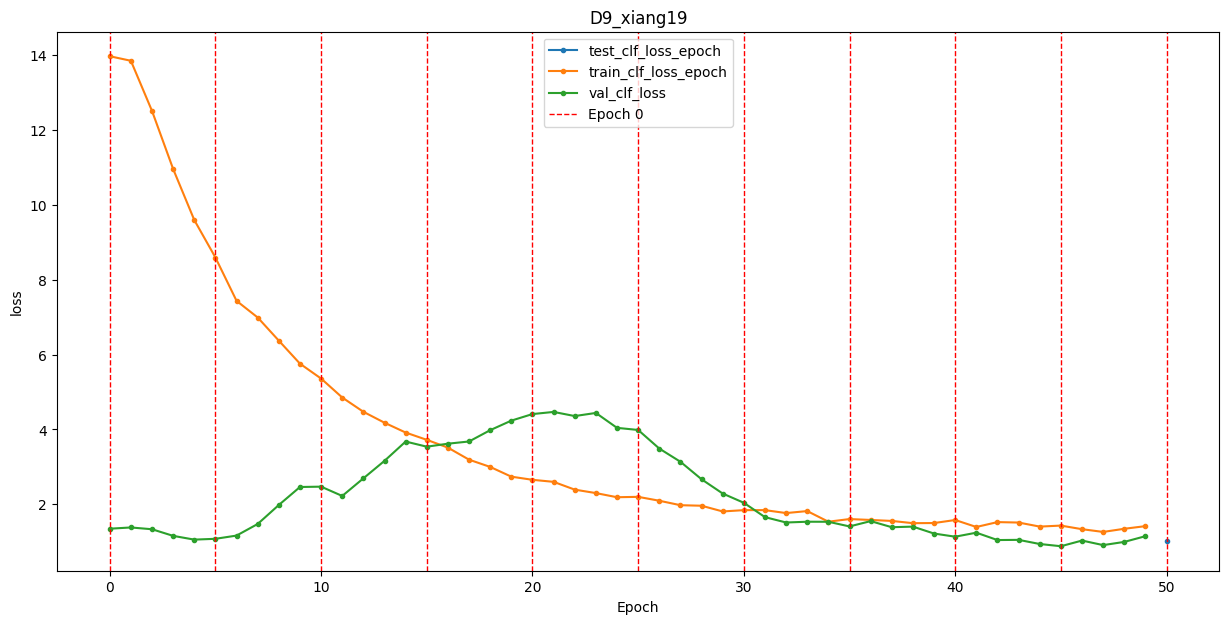

2025-07-27 23:24:09,851 INFO - TemporalVAE.utils.utils_plot - plot training process. 
2025-07-27 23:24:09,871 INFO - tensorboard - Directory watcher advancing from /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D9_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676616.woody.3041196.13 to /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/D9_xiang19/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1753676649.woody.3041196.14 
2025-07-27 23:24:09,872 INFO - tensorboard - No path f

=== data correlation: 
Spearman correlation=0.91815, p-value=0.00000; 
Pearson correlation=0.93814, p-value=0.00000; 
Kendall correlation=0.77371, p-value=0.00000; 
R-squared=0.82223.


<Figure size 1500x700 with 0 Axes>

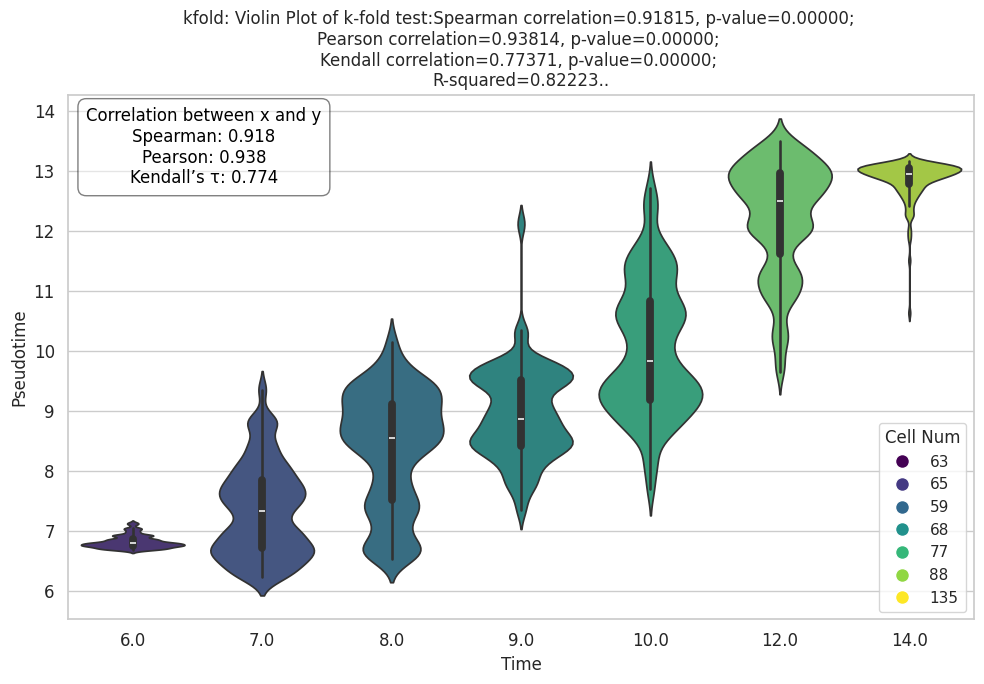

2025-07-27 23:24:10,478 INFO - __main__ - Finish plot image and fold-test. 
2025-07-27 23:24:10,480 INFO - __main__ - Finish fold-test. 


figure save as /ssd/users/yuanhua/MyGit/TemporalVAE-release/examples/results/Fig4_TemporalVAE_kFoldOn_humanEmbryo_xiang2019_250713/human_embryo_preimplantation/integration_8dataset/supervise_vae_regressionclfdecoder_mouse_stereo_dim50_timeembryoneg5to5_epoch50_minGeneNum50/kfold_violine.png


In [19]:
predict_donors_dic, label_dic = task_kFoldTest(
    donor_list, sc_expression_df, donor_dic, batch_dic, 
    special_path_str, cell_time, time_standard_type,
    config, train_epoch_num, _logger, donor_str="day", 
    batch_size=batch_size, cmap_color="viridis"
)

_logger.info("Finish fold-test.")